#  Использование предобученных моделей для классификации изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/vision/stable/models.html
* https://albumentations.ai/docs/getting_started/image_augmentation/

## Задачи для совместного разбора

1\. Загрузите предобученную модель из `torchvision`. Познакомьтесь с ее архитектурой. Заморозьте веса нескольких слоев.

In [ ]:
from torchvision.models import efficientnet_b1
import torchvision.models as models

In [ ]:
model = efficientnet_b1(weights=models.EfficientNet_B1_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 149MB/s]


In [ ]:
import torch as th

In [ ]:
imgs = th.randint(0, 255, size=(16, 3, 500, 500)).float()

In [ ]:
t = models.EfficientNet_B1_Weights.IMAGENET1K_V.transforms()

In [ ]:
y = model(imgs)

In [ ]:
y.shape

torch.Size([16, 1000])

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
import torch.nn as nn
n_classes = 13
model.classifier = nn.Linear(in_features=1280, out_features=n_classes)

In [ ]:
for name, params in model.named_parameters():
  print(name)
  print(params.requires_grad)
  params.requires_grad_(False)
  print(params.requires_grad)
  break

features.0.0.weight
False
False


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию из `torchvision`, cоздайте модель `vgg16` и загрузите предобученные веса `IMAGENET1K_V1`. Выведите на экран структуру модели, количество слоев и количество настраиваемых (`requires_grad==True`) параметров модели.

- [x] Проверено на семинаре

In [ ]:
from torchvision.models import vgg16
import torchvision.models as models

In [ ]:
model = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.0MB/s]


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
tp = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
k = 0
for name, modules in model.named_children():
  layers = sum([1 for _ in modules.children()])
  if layers == 0:
    k += 1
  else:
    k += layers

In [ ]:
print(f'количество слоев= {k}')
print(f'количество настраиваемых параметров модели= {tp}')

количество слоев= 39
количество настраиваемых параметров модели= 138357544


<p class="task" id="2"></p>

2\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

К обучающему датасету примените следующее преобразование: приведите картинки к размеру 256x256, затем обрежьте по центру с размером 224х224, затем переведите изображения в тензор и нормализуйте значения интенсивности пикселей (`mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`).

К тестовому датасету примените преобразование `VGG16_Weights.IMAGENET1K_V1.transforms`.

- [ ] Проверено на семинаре

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch
from torchvision.models import vgg16
import torchvision.models as models

In [ ]:
!wget 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/oHw1WSPwrb9ubw'

--2023-10-31 13:00:06--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/oHw1WSPwrb9ubw
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/c72b9e582fe66a038dc6d701e7266661d9c098cd8d53570304f3b23447b84468/654117b2/0oFllvTGFfdpIBeA8vFr8SHgeTsMkF_XYKJk_5F9Hkck6vuSfIkGqWw0kAY64UYkYIGLoeyPXZlhSRlJEOBjyQ%3D%3D?uid=0&filename=cat_breeds_4.zip&disposition=attachment&hash=9eQ1tj3CYiwPSoVInxZ69JVo4Rntd3Od7X3snHglIibPn31XkinpdxNoJ2DfAoZeq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=982420194&fsize=68706960&hid=7856e8faaab749eccad8c80b9aba7b5d&media_type=compressed&tknv=v2 [following]
--2023-10-31 13:00:07--  https://downloader.disk.yandex.ru/disk/c72b9e582fe66a038dc6d701e7266661d9c098cd8d53570304f3b23447b84468/654117b2/0oFllvTGFfdpIBeA8vFr8SHgeT

In [ ]:
from zipfile import ZipFile

with ZipFile('oHw1WSPwrb9ubw') as zip:
  ZipFile.extractall(zip)

In [ ]:
CatBreeds = ImageFolder(
    'cat_breeds_4'
)

In [ ]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

transform_norm = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
train_dataset = DataLoader(
    ImageFolder(
    'cat_breeds_4',
    transform=transform_norm
    ),
    batch_size=120,
    sampler=range(0, int(0.8 * len(CatBreeds)))
)

In [ ]:
test_dataset = DataLoader(
    ImageFolder(
    'cat_breeds_4',
    transform=models.VGG16_Weights.IMAGENET1K_V1.transforms()
    ),
    batch_size=120,
    sampler=range(int(0.8 * len(CatBreeds)), len(CatBreeds))
)

<p class="task" id="3"></p>

3\. Заморозьте все веса модели из предыдущего задания. Замените последний слой `Linear` классификатора на новый слой, соответствующий задаче. После изменения последнего слоя выведите на экран количество настраиваемых (`requires_grad==True`) параметров модели. Решите задачу, используя модель с замороженными весами и изменнным последним слоем.

Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
CatBreeds.classes

['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']

In [ ]:
import torch.nn as nn

for name, params in model.named_parameters():
  params.requires_grad_(False)

n_classes = len(CatBreeds.classes)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=n_classes)
model.classifier[-1].requires_grad_(True)

Linear(in_features=4096, out_features=4, bias=True)

In [ ]:
tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'количество настраиваемых параметров модели= {tp}')

количество настраиваемых параметров модели= 16388


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
import torchmetrics
import torch.optim as optim
import torch as th

In [ ]:
device = th.device(
    "cuda") if th.cuda.is_available() else th.device("cpu")
print(device)

cuda


In [ ]:
model = model.to(device)

In [ ]:
%%time
lr = 0.1
n_epochs = 10

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
train_acc, test_acc = [], []

for epoch in range(n_epochs):
    print(epoch)
    train_losses = []
    acc_m = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)
    for X_, y_ in train_dataset:
        out = model(X_.to(device=device))
        loss = crit(out, y_.to(device=device))
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()
        acc_m.update(out.argmax(dim=1).to(device='cpu'), y_)

    losses.append(th.tensor(train_losses).mean())
    acc_epochs = acc_m.compute()
    train_acc.append(acc_epochs)

    model.eval()
    for X_test, y_test in test_dataset:
        out = model(X_test.to(device=device))
        acc_m.update(out.argmax(dim=1).to(device='cpu'), y_test)
    acc_epochs_test = acc_m.compute()
    test_acc.append(acc_epochs_test)
    model.train()

0
1
2
3
4
5
6
7
8
9
CPU times: user 6min 3s, sys: 14.8 s, total: 6min 18s
Wall time: 6min 29s


In [ ]:
acc_epochs_test

tensor(0.6085)

In [ ]:
acc_epochs_test

tensor(0.6085)

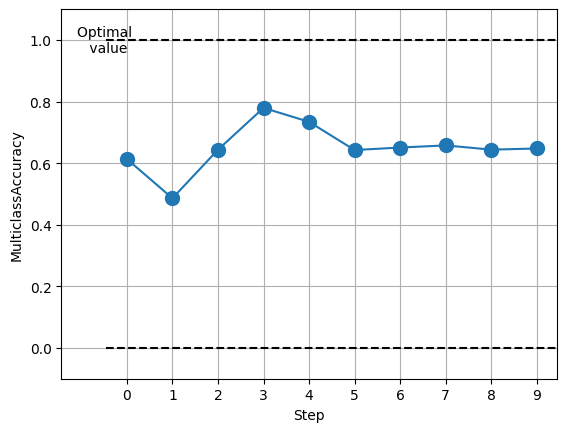

In [ ]:
acc_m.plot(train_acc);

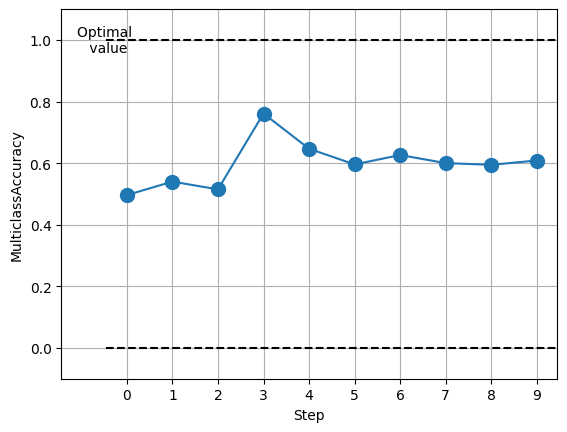

In [ ]:
acc_m.plot(test_acc);

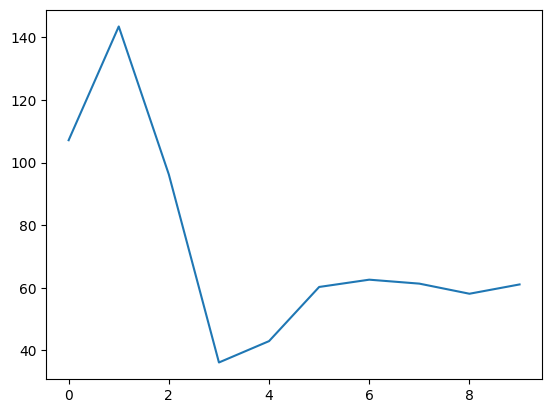

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses);

<p class="task" id="4"></p>

4\. Повторите решение предыдущей задачи, заморозив все сверточные слои, кроме последнего (слои классификатора не замораживайте). Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.

- [ ] Проверено на семинаре

In [ ]:
for name, params in model.named_parameters():
  params.requires_grad_(False)

n_classes = len(CatBreeds.classes)

model.features[26].requires_grad_(True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=n_classes)
model.classifier[-1].requires_grad_(True)

Linear(in_features=4096, out_features=4, bias=True)

In [ ]:
tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'количество настраиваемых параметров модели= {tp}')

количество настраиваемых параметров модели= 2376196


In [ ]:
model = model.to(device)

In [ ]:
%%time
lr = 0.1
n_epochs = 10

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
train_acc, test_acc = [], []

for epoch in range(n_epochs):
    print(epoch)
    train_losses = []
    acc_m = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)
    for X_, y_ in train_dataset:
        out = model(X_.to(device=device))
        loss = crit(out, y_.to(device=device))
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()
        acc_m.update(out.argmax(dim=1).to(device='cpu'), y_)

    losses.append(th.tensor(train_losses).mean())
    acc_epochs = acc_m.compute()
    train_acc.append(acc_epochs)

    model.eval()
    for X_test, y_test in test_dataset:
        out = model(X_test.to(device=device))
        acc_m.update(out.argmax(dim=1).to(device='cpu'), y_test)
    acc_epochs_test = acc_m.compute()
    test_acc.append(acc_epochs_test)
    model.train()

0
1
2
3
4
5
6
7
8
9
CPU times: user 6min 11s, sys: 14.9 s, total: 6min 26s
Wall time: 6min 27s


In [ ]:
acc_epochs

tensor(0.0934)

In [ ]:
acc_epochs_test

tensor(0.0750)

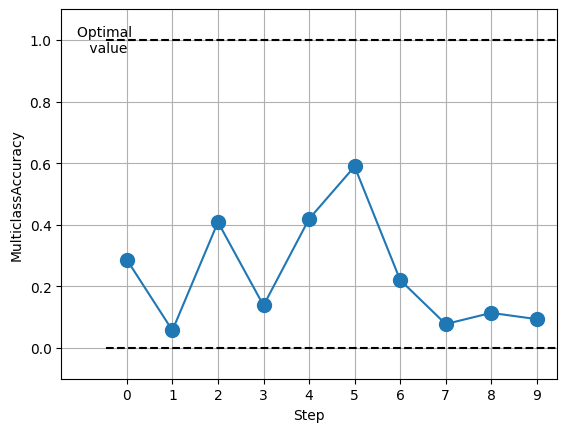

In [ ]:
acc_m.plot(train_acc);

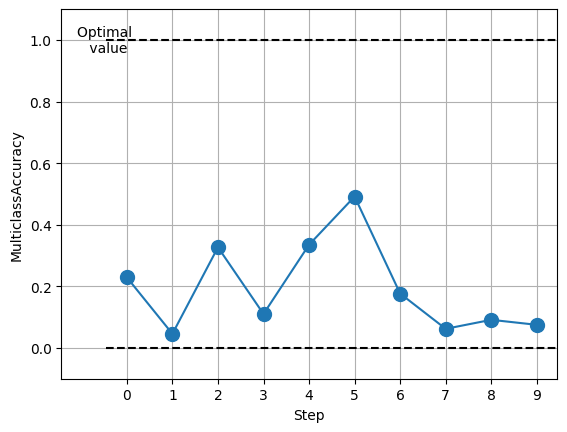

In [ ]:
acc_m.plot(test_acc);

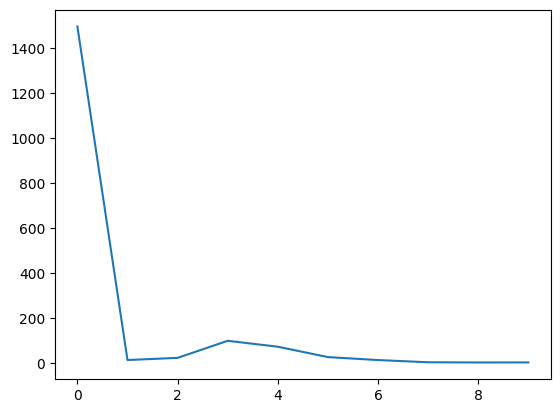

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses);

<p class="task" id="5"></p>

5\. Повторите решение задачи, расширив обучающий набор данных при помощи преобразований из `torchvision`, изменяющих изображение (повороты, изменение интенсивности пикселей, обрезание и т.д.). При оценке модели на тестовой выборке данные преобразования применяться не должны. Решение о том, сколько и каких слоев модели будет обучаться, примите самостоятельно.

- [ ] Проверено на семинаре

In [ ]:
transform_norm = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    T.Normalize(mean, std),
    T.RandomGrayscale(),
    T.RandomRotation(90)
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
train_dataset_ = DataLoader(
    ImageFolder(
    'cat_breeds_4',
    transform=transform_norm
    ),
    batch_size=120,
    sampler=range(0, int(0.8 * len(CatBreeds)))
)

In [ ]:
for name, params in model.named_parameters():
  params.requires_grad_(False)

n_classes = len(CatBreeds.classes)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=n_classes)
model.classifier[-1].requires_grad_(True)

Linear(in_features=4096, out_features=4, bias=True)

In [ ]:
model = model.to(device)

In [ ]:
tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'количество настраиваемых параметров модели= {tp}')

количество настраиваемых параметров модели= 16388


In [ ]:
%%time
lr = 0.1
n_epochs = 10

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
train_acc, test_acc = [], []

for epoch in range(n_epochs):
    print(epoch)
    train_losses = []
    acc_m = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)
    for X_, y_ in train_dataset:
        out = model(X_.to(device=device))
        loss = crit(out, y_.to(device=device))
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()
        acc_m.update(out.argmax(dim=1).to(device='cpu'), y_)

    losses.append(th.tensor(train_losses).mean())
    acc_epochs = acc_m.compute()
    train_acc.append(acc_epochs)

    model.eval()
    for X_test, y_test in test_dataset:
        out = model(X_test.to(device=device))
        acc_m.update(out.argmax(dim=1).to(device='cpu'), y_test)
    acc_epochs_test = acc_m.compute()
    test_acc.append(acc_epochs_test)
    model.train()

0
1
2
3
4
5
6
7
8
9
CPU times: user 6min 1s, sys: 14.6 s, total: 6min 15s
Wall time: 6min 15s


In [ ]:
acc_epochs

tensor(0.0297)

In [ ]:
acc_epochs_test

tensor(0.0237)

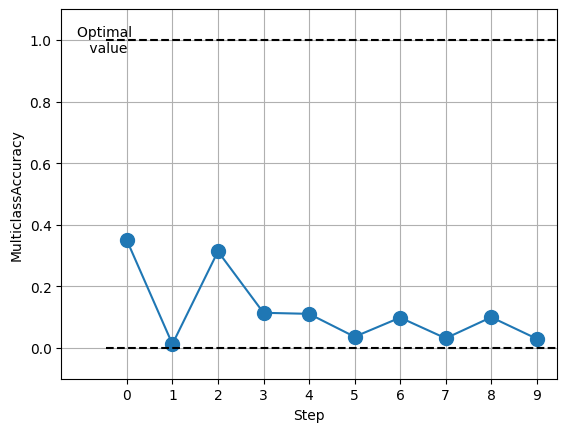

In [ ]:
acc_m.plot(train_acc);

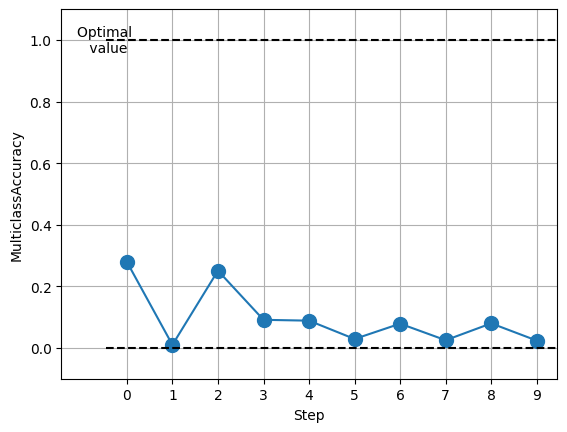

In [ ]:
acc_m.plot(test_acc);

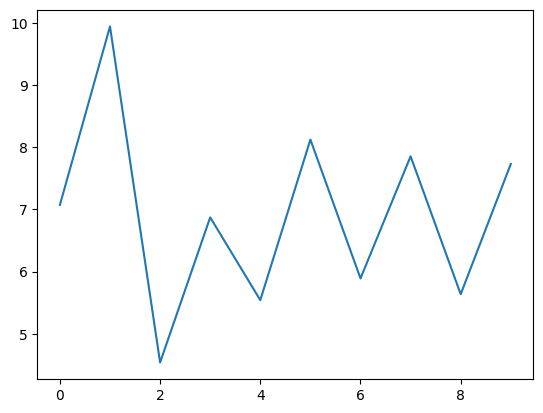

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses);

## Обратная связь
- [x] Хочу получить обратную связь по решению